# Setup

In [1]:
using Pkg

In [2]:
Pkg.status()

Status `~/.julia/environments/v1.5/Project.toml`
  [0c46a032] DifferentialEquations v6.16.0
  [31c24e10] Distributions v0.24.12
  [38e38edf] GLM v1.3.11
  [7073ff75] IJulia v1.23.1
  [a98d9a8b] Interpolations v0.13.1
  [c7f686f2] MCMCChains v4.6.0
  [6f286f6a] MultivariateStats v0.7.0
  [65888b18] ParameterizedFunctions v5.9.0
  [91a5bcdd] Plots v1.10.2
  [f3b207a7] StatsPlots v0.14.17
  [9f7883ad] Tracker v0.2.15
  [fce5fe82] Turing v0.15.8


In [3]:
Pkg.status("DiffEqBase")

No Matches in `~/.julia/environments/v1.5/Project.toml`


In [4]:
Pkg.add(Pkg.PackageSpec(;name="DiffEqBase", version="6.57.1"))

   Updating registry at `~/.julia/registries/General`
tar: Failed to set default locale
tar: Failed to set default locale
######################################################################### 100.0%
tar: Failed to set default locale
  Resolving package versions...
tar: Failed to set default locale
  Installed DiffEqBase ─ v6.57.1
Updating `~/.julia/environments/v1.5/Project.toml`
  [2b5f629d] + DiffEqBase v6.57.1
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [2b5f629d] ↑ DiffEqBase v6.53.6 ⇒ v6.57.1


In [5]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1278


# Three node network

In [6]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

In [11]:
function additive_noise!(du,u,p,t)
#     s,g,W,I,ϕ = p
#     s,g,W,ϕ = p
    s,g,ϕ = p
    for i = 1:length(u)
        du[i] = ϕ #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
    end
end

function network_model!(du,u,p,t)
#     s,g,W,I,ϕ = p
#     s,g,W,ϕ = p
    s,g,ϕ = p
    for i=1:length(u)
#         du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + I(t)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u))
    end
end

network_model! (generic function with 1 method)

In [12]:
num_nodes = 3
u0 = repeat([0.0], num_nodes)
Tmax = 100.0
tspan = (0,Tmax)

# s = 0.3
# g = 0.7
W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

ts = 1:1:Tmax
task = repeat([0.0], 100)
# task[4] = 1 #without impulse it'd be "resting state"
# I = LinearInterpolation(ts, task, extrapolation_bc = 0)
dt = 0.5
# ϕ = 0.1

# p = [s,g,W,I,ϕ]
# p = [0.3, 0.7, [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0], LinearInterpolation(ts, task, extrapolation_bc = 0), 0.1]
# p = [0.3, 0.7, [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0], 0.1]
p = [0.3, 0.7, 0.1]

prob_sde = SDEProblem(network_model!,additive_noise!,u0,tspan,p)


SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [0.0, 0.0, 0.0]

In [14]:
eltype(p)

Float64

Note: If you don't turn off adaptive step size then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control)

In [ ]:
# sol = solve(prob_sde, dt=dt, adaptive=false)

In [ ]:
# plot(sol)

In [38]:
ensembleprob = EnsembleProblem(prob_sde)
data = solve(ensembleprob, SOSRI(), trajectories=100, dt=dt, adaptive=false, saveat=dt)
# data = solve(ensembleprob, SOSRI(), trajectories=100)

EnsembleSolution Solution of length 100 with uType:
RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SOSRI,StochasticDiffEq.LinearInterpol

In [ ]:
plot(EnsembleSummary(data))

In [39]:
Turing.setadbackend(:forwarddiff)
@model function fit_nmm(data, prob)
    σ ~ InverseGamma(2,3)
    ϕ ~ truncated(Normal(0.0,1.1),-3.0,3.0)
#     ϕ = 0.1
    s = 0.3
    g = 0.7
    W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]
#     ts = 1:1:Tmax
#     task = repeat([0.0], 100)
#     I = LinearInterpolation(ts, task, extrapolation_bc = 0)
#     p = [s,g,W,I,ϕ]
#     p = [s,g,W,ϕ]
    p = [s,g,ϕ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i],σ) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [40]:
model = fit_nmm(data, prob_sde)

DynamicPPL.Model{var"#4#5",(:data, :prob),(),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(network_model!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SO

In [41]:
chain = sample(model, NUTS(0.25), 100)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/zeynepenkavi/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/zeynepenkavi/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/zeynepenkavi/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/zeynepenkavi/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/zeynepenka

Chains MCMC chain (100×14×1 Array{Float64,3}):

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = σ, ϕ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Missing   Float64   Float64 

           σ    0.1078    0.0042     0.0004   missing    1.7095    1.6095
           ϕ   -0.0023    0.0014     0.0001   missing    2.3124    1.4291

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0996    0.1025    0.1106    0.1106    0.1106
           ϕ   -0.0032   -0.0032   -0.0032   -0.0005    0.0008


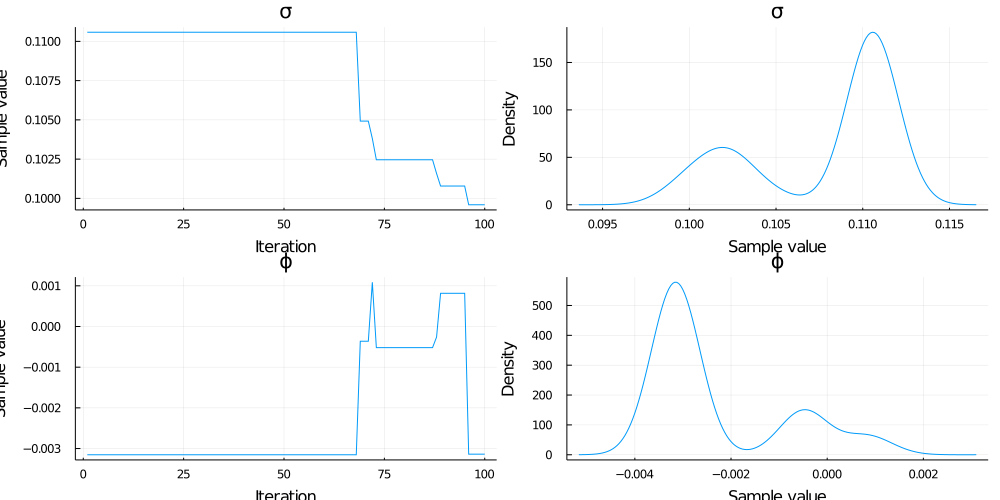

In [50]:
plot(chain)